# Reconstruction of brain FDG PET acquired on Siemens Biograph mMR 
Load listmode data of a brain FDG scan acquired on Siemens Biograph mMR and reconstruct using OSEM. Compare the reconstruction with the reconstruction obtained with the Siemens E7 Tools using the same parameters of the OSEM algorithm. 

In [1]:
from occiput.Reconstruction.PET import PET_Static_Scan
from Occiput_Interface_Biograph_mMR import Biograph_mMR
from occiput.DataSources.FileSources import import_interfile_volume
from occiput.DataSources.FileSources import import_nifti

In [2]:
# Static PET reconstruction - Biograph mMR scanner 
pet = PET_Static_Scan()
pet.set_scanner(Biograph_mMR)

In [3]:
# Enable/disable sinogram compression mode
pet.use_compression(False)

### LOAD MEASUREMENT DATA (90 min)

In [4]:
datapath = '../../data/PET_data/scans/2014_09_05_brain_nf_014_base/'

In [5]:
from interfile import Interfile
header = Interfile.load(datapath+'listmode_and_sensitivity/PET_ACQ_506_20140905145126-0.l.hdr')
print "The acquisition is",header['image duration']['value']/60,"minutes"

The acquisition is 90 minutes


In [6]:
# Load measurement data 
listmode = 0
if listmode:
    pet.import_listmode(datapath+'listmode_and_sensitivity/PET_ACQ_506_20140905145126-0.l.hdr')
    pet.export_prompts(datapath+'occiput/prompts.h5')
    pet.export_randoms(datapath+'occiput/randoms.h5')
else:
    #pet.import_prompts(datapath+'sinogram/brain_s_time5400_dc_prompts_00.s.hdr')
    pet.import_prompts(datapath+'occiput/prompts.h5')
    pet.import_randoms(datapath+'occiput/randoms.h5')

In [7]:
# Load sensitivity
pet.import_sensitivity(datapath+'listmode_and_sensitivity/norm3d_00.h33')

In [8]:
# Load attenuation
pet.import_attenuation(filename=datapath+'mumap_JSRecon/JSRecon-00-umap.v.hdr', 
                       filename_hardware=datapath+'mumap_JSRecon/JSRecon-00-umap-hardware.v.hdr')

In [9]:
# Import randoms: 
pet.import_randoms(datapath+'output/smoothed_rand_00.h33')

In [10]:
# Import scatter 
pet.import_scatter(datapath+'scatter/brain_scatter3D.s.hdr')

#### Crop projection data around the brain and use zoomed reconstruction to improve speed

In [11]:
#pet.set_activity_shape([128,128,128])
#pet.set_activity_size([128*pet.activity_size[0]/344.0,128*pet.activity_size[1]/344.0,128*pet.activity_size[2]/127.0])

pet.brain_crop()

In [12]:
attenuation_projection = pet.project_attenuation(pet.attenuation)

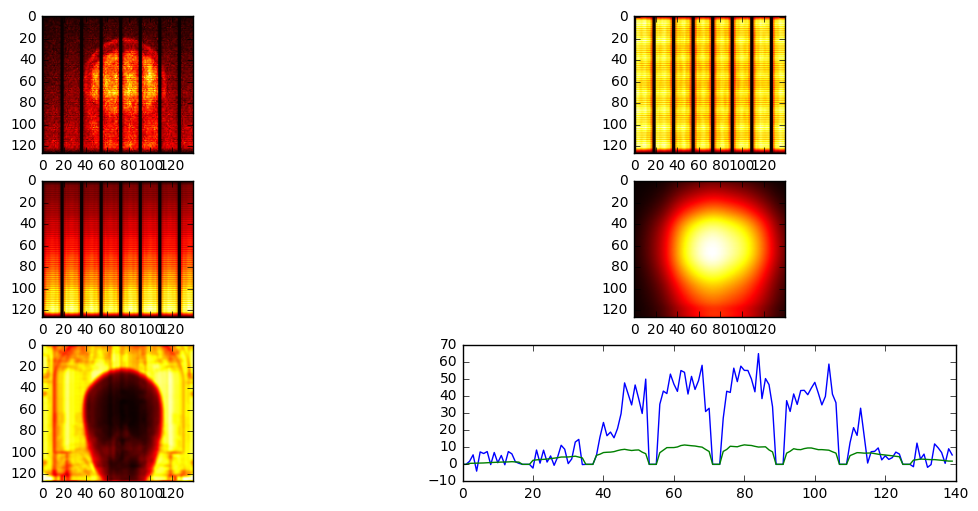

In [17]:
figure(figsize=[14,6])
subplot(3,2,1); imshow(flipud(pet.prompts.to_nd_array()[0,5,:,:].transpose()),cmap='hot')
subplot(3,2,2); imshow(flipud(pet.sensitivity.to_nd_array()[0,5,:,:].transpose()),cmap='hot')
subplot(3,2,3); imshow(flipud(pet.randoms.to_nd_array()[0,5,:,:].transpose()),cmap='hot')
subplot(3,2,4); imshow(flipud(pet.scatter.to_nd_array()[0,5,:,:].transpose()),cmap='hot')
subplot(3,2,5); imshow(flipud(pet.attenuation_projection.to_nd_array()[0,5,:,:].transpose()),cmap='hot')
subplot(3,2,6); pet.quick_inspect()

### RECONSTRUCT

In [18]:
iterations = 10
subset_mode = "random"
subset_size = 64

In [36]:
from occiput.Reconstruction.PET import RigidTransform
#r = RigidTransform( [0,0,0,0,0,pi/4] )
r = RigidTransform( [0,0,0,0,0,0] )

In [37]:
# Reconstruct activity
activity_recon = pet.osem_reconstruction(iterations=iterations, subset_mode=subset_mode, subset_size=subset_size, transformation=r)

0
1
2
3
4
5
6
7
8
9


In [38]:
activity_recon.save_to_file(datapath+'occiput/activity_recon.nii')

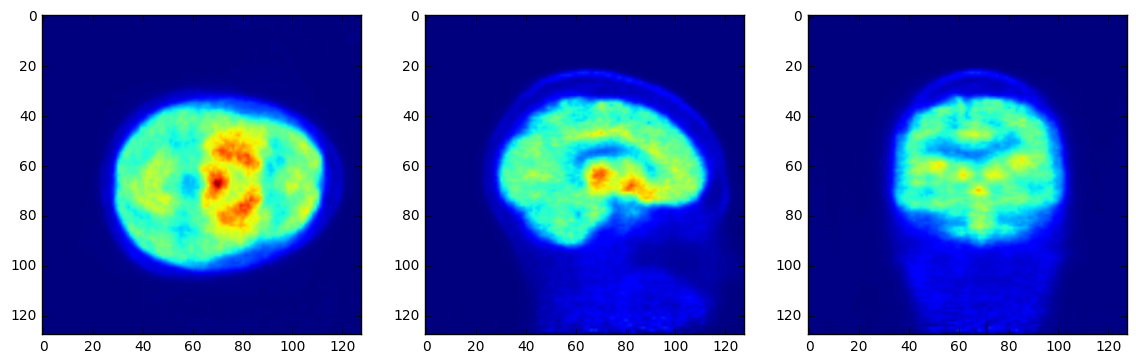

In [39]:
figure(figsize=[14,6])
subplot(1,3,1); imshow(activity_recon.data[:,:,pet.activity_shape[2]/2].transpose(),vmax = 5.0)
subplot(1,3,2); imshow(activity_recon.data[:,pet.activity_shape[1]/2,:].transpose(),vmax = 5.0)
subplot(1,3,3); imshow(activity_recon.data[pet.activity_shape[0]/2,:,:].transpose(),vmax = 5.0)

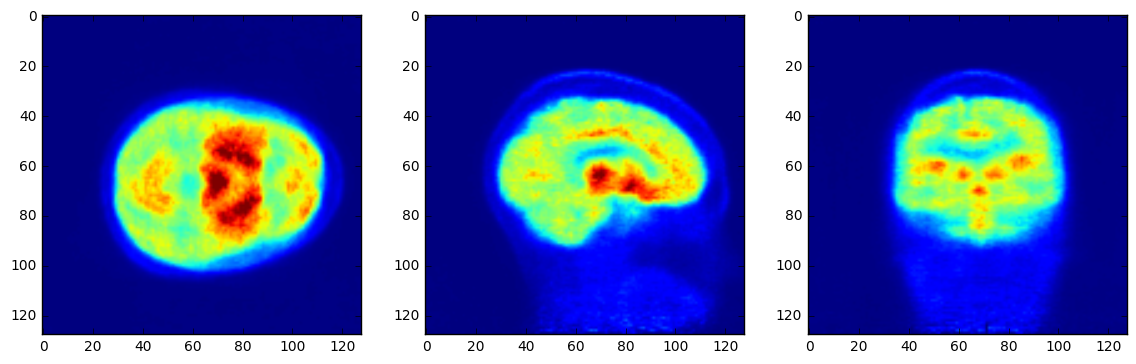

In [45]:
figure(figsize=[14,6])
subplot(1,3,1); imshow(activity_recon.data[:,:,pet.activity_shape[2]/2].transpose(),vmax = 4.0)
subplot(1,3,2); imshow(activity_recon.data[:,pet.activity_shape[1]/2,:].transpose(),vmax = 4.0)
subplot(1,3,3); imshow(activity_recon.data[pet.activity_shape[0]/2,:,:].transpose(),vmax = 4.0)

### Compare with Siemens E7 Tools

In [41]:
activity_Siemens = import_interfile_volume(datapath+'reconstructions/brain_uncomp_000_000.v.hdr')
activity_occiput = import_nifti(datapath+'occiput/activity_recon.nii')

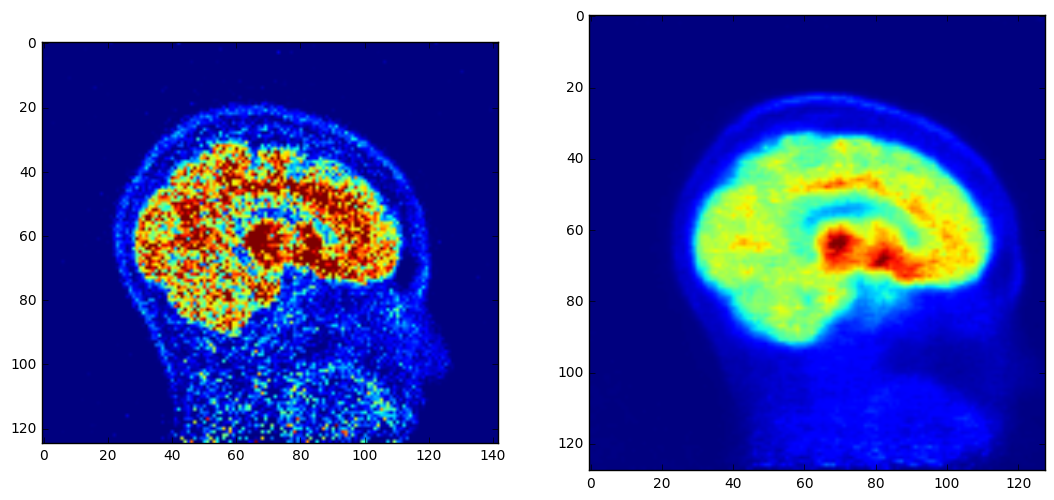

In [46]:
figure(figsize=[20,9])
subplot(1,3,1); imshow(activity_Siemens.data[110:252,172,1:126].transpose(),vmax = 4.0)
subplot(1,3,2); imshow(activity_recon.data[:,pet.activity_shape[1]/2,:].transpose(),vmax = 4.0)